In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt  # Para graficar la pérdida
from StyleTransferNetwork import StyleTransferNetwork, ResidualBlock

def load_image(image_path, size=(512, 512)):
    """Enhanced image loading with better preprocessing"""
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.05, contrast=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    return image

def get_vgg_model():
    """Load and prepare VGG model with specific layers for feature extraction"""
    vgg = models.vgg19(pretrained=True).features
    # Freeze VGG parameters
    for param in vgg.parameters():
        param.requires_grad_(False)
    return vgg.to(torch.device("mps" if torch.backends.mps.is_available() else "cpu"))

def get_features(image, model, layers=None):
    """Extract features from specific VGG layers"""
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '28': 'conv5_1'
        }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

def gram_matrix(tensor):
    """Calculate Gram Matrix with normalized values"""
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram / (d * h * w)  # Normalize by size

def load_style_images(style_dir, max_images=10):
    """Carga un conjunto de imágenes de estilo."""
    style_images = []
    for img_name in os.listdir(style_dir):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            try:
                img = load_image(os.path.join(style_dir, img_name))
                style_images.append(img.to(torch.device("mps" if torch.backends.mps.is_available() else "cpu")))
            except Exception as e:
                print(f"Error al cargar {img_name}: {e}")
            if len(style_images) >= max_images:
                break
    return style_images

def calculate_average_gram_matrix(style_images, vgg_model):
    """Calcula la matriz de Gram promedio para capturar el estilo."""
    gram_matrices = []
    for style_image in style_images:
        style_features = get_features(style_image, vgg_model)
        style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
        gram_matrices.append(style_grams)
    
    averaged_style_grams = {}
    for layer in gram_matrices[0]:
        layer_grams = [grams[layer] for grams in gram_matrices]
        averaged_style_grams[layer] = sum(layer_grams) / len(layer_grams)  # Promedio de cada capa
    
    return averaged_style_grams

def train_style_model(averaged_style_grams, model, vgg, style_weight=1e6, tv_weight=1e-6, epochs=2000, lr=1e-3):
    """Entrena el modelo de estilo para capturar solo el estilo."""
    device = next(model.parameters()).device
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)
    
    # Pesos específicos de capas para la pérdida de estilo
    style_weights = {
        'conv1_1': 1.0,
        'conv2_1': 0.8,
        'conv3_1': 0.4,
        'conv4_1': 0.2,
        'conv5_1': 0.2
    }
    
    best_loss = float('inf')
    best_state = None
    
    # Crear una imagen aleatoria como "contenido ficticio"
    dummy_content = torch.randn(1, 3, 512, 512, device=device, requires_grad=True)
    
    # Lista para guardar los valores de la pérdida en cada epoch
    loss_history = []

    for epoch in tqdm(range(epochs), desc="Entrenando"):
        model.train()
        optimizer.zero_grad()
        
        # Generar imagen estilizada ficticia
        styled = model(dummy_content)
        styled_features = get_features(styled, vgg)
        
        # Pérdida de estilo usando matrices de Gram promedio
        style_loss = 0
        for layer in averaged_style_grams:
            styled_gram = gram_matrix(styled_features[layer])
            style_gram = averaged_style_grams[layer].to(device)
            layer_style_loss = torch.mean((styled_gram - style_gram) ** 2) * style_weights[layer]
            style_loss += layer_style_loss
        
        # Pérdida de variación total para suavizar la imagen
        tv_loss = torch.mean(torch.abs(styled[:, :, :, :-1] - styled[:, :, :, 1:])) + \
                  torch.mean(torch.abs(styled[:, :, :-1, :] - styled[:, :, 1:, :]))
        
        # Pérdida total
        total_loss = style_weight * style_loss + tv_weight * tv_loss
        total_loss.backward()
        optimizer.step()
        
        # Ajustar el programador de tasa de aprendizaje
        scheduler.step()
        
        # Guardar el mejor modelo
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_state = model.state_dict().copy()
        
        # Almacenar la pérdida de cada época para graficarla después
        loss_history.append(total_loss.item())
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Style Loss: {style_loss.item():.4f}")
            print(f"TV Loss: {tv_loss.item():.4f}")
            print(f"Total Loss: {total_loss.item():.4f}")
            print("-------------------")
    
    # Cargar el mejor estado del modelo
    model.load_state_dict(best_state)
    
    # Graficar la pérdida al finalizar el entrenamiento
    plt.plot(loss_history)
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida Total')
    plt.title('Evolución de la Pérdida Durante el Entrenamiento')
    plt.show()
    
    return model

def train_and_save_style_models(dataset_path, max_images=10):
    """Entrena modelos para cada estilo en el dataset y los guarda."""
    styles = [style for style in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, style))]
    vgg = get_vgg_model()
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    for style in styles:
        print(f"\nEntrenando para el estilo: {style}")
        style_dir = os.path.join(dataset_path, style)
        
        # Cargar imágenes de estilo
        style_images = load_style_images(style_dir, max_images=max_images)
        
        if style_images:
            # Calcular matrices de Gram promedio
            averaged_style_grams = calculate_average_gram_matrix(style_images, vgg)
            
            # Inicializar y entrenar el modelo para capturar el estilo
            style_model = StyleTransferNetwork().to(device)
            trained_model = train_style_model(
                averaged_style_grams=averaged_style_grams,
                model=style_model,
                vgg=vgg,
                style_weight=1e5,
                tv_weight=1e-6,
                epochs=500
            )
            
            # Guardar el modelo
            model_path = f"{style.lower().replace(' ', '_')}_style_model.pth"
            torch.save(trained_model, model_path)
            print(f"Modelo guardado en {model_path}")
        else:
            print(f"No se encontraron imágenes válidas en el directorio de estilo: {style}")


/opt/homebrew/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Entrenando para el estilo: Modern_Art


Entrenando:  20%|██        | 100/500 [00:27<01:37,  4.09it/s]

Epoch 100/500
Style Loss: 0.0000
TV Loss: 0.3338
Total Loss: 1.7014
-------------------


Entrenando:  40%|████      | 200/500 [00:52<01:13,  4.07it/s]

Epoch 200/500
Style Loss: 0.0000
TV Loss: 0.4001
Total Loss: 0.7100
-------------------


Entrenando:  60%|██████    | 300/500 [01:16<00:48,  4.09it/s]

Epoch 300/500
Style Loss: 0.0000
TV Loss: 0.4063
Total Loss: 0.4409
-------------------


Entrenando:  80%|████████  | 400/500 [01:41<00:24,  4.01it/s]

Epoch 400/500
Style Loss: 0.0000
TV Loss: 0.4039
Total Loss: 0.3039
-------------------


Entrenando: 100%|██████████| 500/500 [02:06<00:00,  3.95it/s]

Epoch 500/500
Style Loss: 0.0000
TV Loss: 0.1812
Total Loss: 3.1823
-------------------


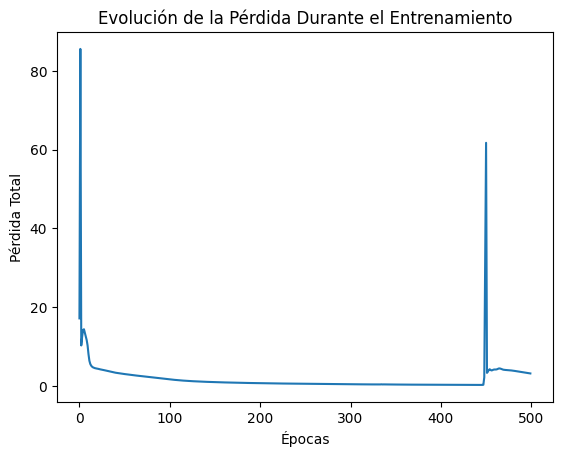

Modelo guardado en modern_art_style_model.pth

Entrenando para el estilo: Cubism


Entrenando:  20%|██        | 100/500 [00:24<01:38,  4.07it/s]

Epoch 100/500
Style Loss: 0.0000
TV Loss: 0.3708
Total Loss: 1.7364
-------------------


Entrenando:  40%|████      | 200/500 [00:49<01:15,  3.99it/s]

Epoch 200/500
Style Loss: 0.0000
TV Loss: 0.3525
Total Loss: 1.0066
-------------------


Entrenando:  60%|██████    | 300/500 [01:16<00:52,  3.82it/s]

Epoch 300/500
Style Loss: 0.0000
TV Loss: 0.3782
Total Loss: 0.5509
-------------------


Entrenando:  80%|████████  | 400/500 [01:42<00:27,  3.64it/s]

Epoch 400/500
Style Loss: 0.0000
TV Loss: 0.3780
Total Loss: 0.3368
-------------------


Entrenando: 100%|██████████| 500/500 [02:08<00:00,  3.89it/s]

Epoch 500/500
Style Loss: 0.0000
TV Loss: 0.3798
Total Loss: 0.2368
-------------------


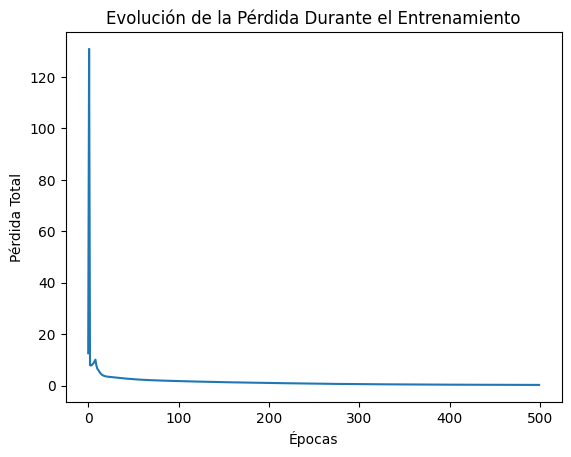

Modelo guardado en cubism_style_model.pth

Entrenando para el estilo: Impressionism


Entrenando:  20%|██        | 100/500 [00:24<01:37,  4.10it/s]

Epoch 100/500
Style Loss: 0.0000
TV Loss: 0.4120
Total Loss: 0.5977
-------------------


Entrenando:  40%|████      | 200/500 [00:49<01:13,  4.09it/s]

Epoch 200/500
Style Loss: 0.0000
TV Loss: 0.4603
Total Loss: 0.3206
-------------------


Entrenando:  60%|██████    | 300/500 [01:13<00:48,  4.11it/s]

Epoch 300/500
Style Loss: 0.0000
TV Loss: 0.4552
Total Loss: 0.2077
-------------------


Entrenando:  80%|████████  | 400/500 [01:38<00:27,  3.64it/s]

Epoch 400/500
Style Loss: 0.0000
TV Loss: 0.4405
Total Loss: 0.1466
-------------------


Entrenando: 100%|██████████| 500/500 [02:04<00:00,  4.01it/s]

Epoch 500/500
Style Loss: 0.0000
TV Loss: 0.4251
Total Loss: 0.1103
-------------------


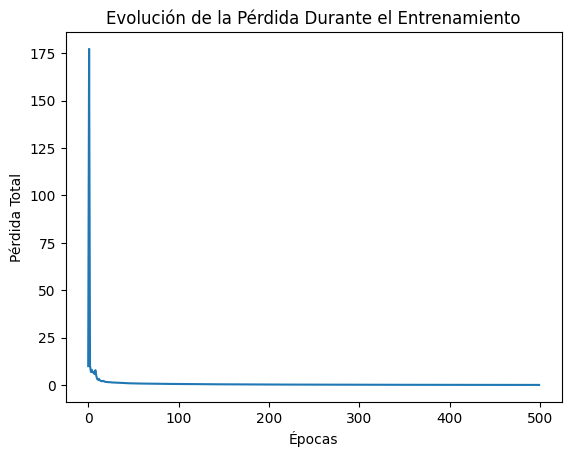

Modelo guardado en impressionism_style_model.pth

Entrenando para el estilo: Baroque


Entrenando:  20%|██        | 100/500 [00:24<01:37,  4.09it/s]

Epoch 100/500
Style Loss: 0.0000
TV Loss: 0.2840
Total Loss: 1.0025
-------------------


Entrenando:  40%|████      | 200/500 [00:49<01:16,  3.93it/s]

Epoch 200/500
Style Loss: 0.0000
TV Loss: 0.2814
Total Loss: 0.6229
-------------------


Entrenando:  60%|██████    | 300/500 [01:14<00:51,  3.88it/s]

Epoch 300/500
Style Loss: 0.0000
TV Loss: 0.2916
Total Loss: 0.4699
-------------------


Entrenando:  80%|████████  | 400/500 [01:39<00:26,  3.75it/s]

Epoch 400/500
Style Loss: 0.0000
TV Loss: 0.2952
Total Loss: 0.3812
-------------------


Entrenando: 100%|██████████| 500/500 [02:04<00:00,  4.01it/s]

Epoch 500/500
Style Loss: 0.0000
TV Loss: 0.2974
Total Loss: 0.3200
-------------------


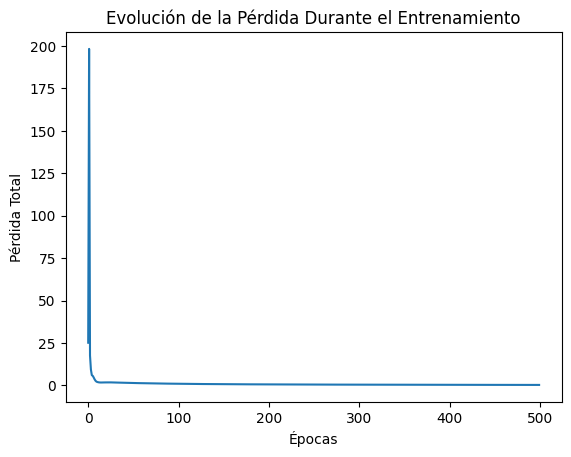

Modelo guardado en baroque_style_model.pth


In [5]:
dataset_path = "../../WikiArt_Dataset"  
train_and_save_style_models(dataset_path, max_images=500)